# Visualisasi

In [14]:
import sys
import subprocess
from os import path
from decimal import Decimal

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
from adjustText import adjust_text
from scipy import interpolate
from decimal import Decimal

%matplotlib inline
plt.style.use('ggplot')

In [2]:
DATA_DIR = path.join(path.pardir, 'data')
PAN_DIR = path.join(DATA_DIR, 'pangenomes')
FIG_DIR = path.join(path.pardir, 'figs')

## Bonferroni Correction

In [4]:
def bonferroni(initial, n_patterns):
    return Decimal(initial / n_patterns)


# Jumlah kmers tiap antibiotik, lihat `count_kmers.txt`
thres_ethambutol = bonferroni(0.05, 1102609188)
thres_isoniazid = bonferroni(0.05, 2539368683)
thres_rifampin = bonferroni(0.05, 1690584957)

thres_ethambutol, thres_isoniazid, thres_rifampin

(Decimal('4.5346982905787288743231720075928616910110324766947087482549250125885009765625E-11'),
 Decimal('1.968993330300120086934525289387178624556096195874488330446183681488037109375E-11'),
 Decimal('2.957556187458729575991541200911429110309569523451500572264194488525390625E-11'))

## 1. k-mers Manhattan Plot

In [5]:
def get_pyseer(antibiotic):
    PYSEER_PATH = path.join(PAN_DIR, antibiotic, 'pyseer', 'pyseer.tsv')
    pyseer = pd.read_csv(PYSEER_PATH, sep='\t')
    return pyseer


def get_cluster2hash(antibiotic):
    KMERS_HASHES_PATH = path.join(PAN_DIR, antibiotic, 'panfeed1', 'kmers_to_hashes.tsv')
    hashes = pd.read_csv(KMERS_HASHES_PATH, sep='\t')
    return hashes


def extract_data(pyseer, cluster2hash):
    variants = pyseer['variant']

    pvalue = pyseer['lrt-pvalue']
    neg_logp = -np.log10(pyseer['lrt-pvalue'])
    neg_logp.name = 'neg_logp'

    cluster = cluster2hash[['cluster', 'hashed_pattern']].drop_duplicates()
    cluster.columns = ['cluster', 'variant']

    data = pd.concat([variants, pvalue, neg_logp], axis=1)
    data = pd.merge(data, cluster, how='left', on='variant')
    data['position'] = data.index
    return data


def create_manhattan_plot(data, antibiotic, threshold, text_focus_threshold):
    threshold = -np.log10(threshold)
    text_focus_threshold = -np.log10(text_focus_threshold)
    
    running_pos = 0
    cumulative_pos = []
    for cluster, group in data.groupby('cluster'):  
        cumulative_pos.append(group['position'] + running_pos)
        running_pos += group['position'].max()
    
    data['cumulative_pos'] = pd.concat(cumulative_pos)
    data['is_selected'] = data['neg_logp'] >= threshold 

    
    g = sns.relplot(
        data=data,
        x='cumulative_pos',
        y='neg_logp',
        alpha=0.6,
        aspect=1.5,
        hue='is_selected',
        palette='colorblind',
        linewidth=0,
        s=25,
        legend=None
    )
    
    g.ax.axhline(threshold, linestyle='--', linewidth=1, color='black', alpha=0.6)
    
    cluster_already = set()
    for _, r in data[(data.neg_logp >= threshold)].iterrows():
        if r.cluster not in cluster_already:
            g.ax.axvline(r.cumulative_pos, linestyle='--', linewidth=0.3, color='black', alpha=0.3)
        cluster_already.add(r.cluster)
        
    
    g.ax.set_xticks([], [])    
    g.ax.set_xlabel('Urutan Gen')
    g.ax.set_ylabel(r'$-\log_{10}$$(p$-$value)$')
    g.fig.suptitle(f'Asosiasi Keberadaan k-mers ({antibiotic.title()})', y=1.03, size='large')

    # Hanya ambil nama gen yang berada di hash paling atas dan melibihi text_focus_threshold
    text_adjust = data[data['neg_logp'] > text_focus_threshold].sort_values('neg_logp', ascending=False).drop_duplicates(['cluster'])
    cluster_annotation = text_adjust.apply(lambda p : g.ax.annotate(p['cluster'], (p['cumulative_pos'], p['neg_logp'])), axis=1).to_list()
    adjust_text(
        cluster_annotation,
        arrowprops = {'arrowstyle': 'simple', 'color': 'black', 'lw': 0.01}
    )
    
    return g


def run_manhattan_pipeline(antibiotic, threshold, text_focus_threshold):
    pyseer = get_pyseer(antibiotic)
    cluster2hash = get_cluster2hash(antibiotic)
    data = extract_data(pyseer, cluster2hash)
    
    g = create_manhattan_plot(data, antibiotic, threshold, text_focus_threshold)  
    g.fig.savefig(path.join(FIG_DIR, f'manhattan_{antibiotic}.png'), format='png', dpi=600, bbox_inches='tight')
    
    if threshold != text_focus_threshold:
        g = create_manhattan_plot(data, antibiotic, threshold, threshold)  
        g.fig.savefig(path.join(FIG_DIR, f'manhattan_{antibiotic}_full_label.png'), format='png', dpi=600, bbox_inches='tight')

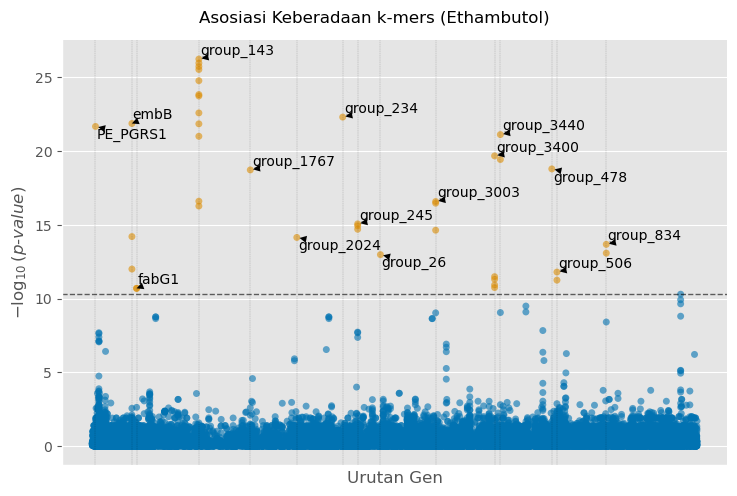

In [6]:
run_manhattan_pipeline('ethambutol', thres_ethambutol, thres_ethambutol)

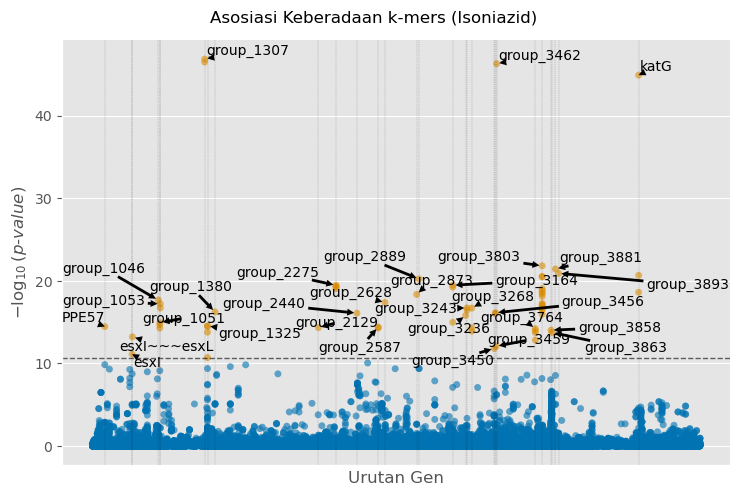

In [7]:
run_manhattan_pipeline('isoniazid', thres_isoniazid, thres_isoniazid)

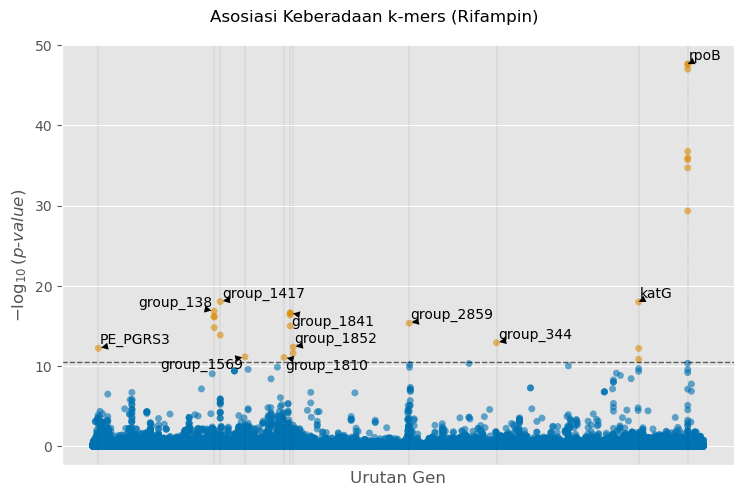

In [8]:
run_manhattan_pipeline('rifampin', thres_rifampin, thres_rifampin)

## 2. Distribusi Sampel

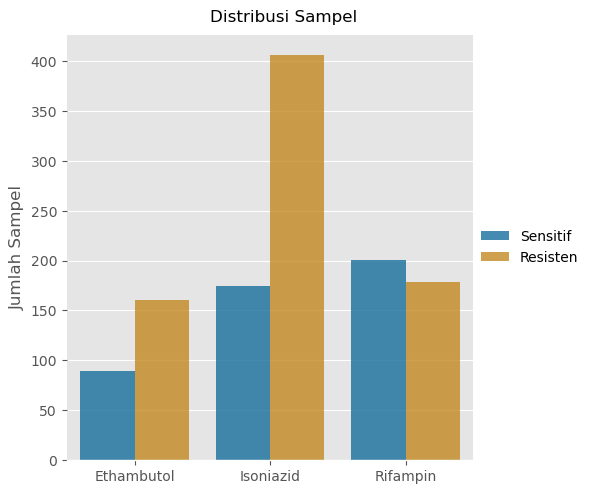

In [9]:
def get_traits(antibiotic):
    return pd.read_csv(path.join(DATA_DIR, f'traits_{antibiotic}.tsv'), sep='\t')


def count_traits(traits):
    return traits.groupby('resistance').count()['samples'].to_dict()


emb = 'ethambutol'
inh = 'isoniazid'
rif = 'rifampin'
r = 'Resisten'
s = 'Sensitif'

emb_count = count_traits(get_traits(emb))
inh_count = count_traits(get_traits(inh))
rif_count = count_traits(get_traits(rif))

distributions = pd.DataFrame(
    [(emb.title(), s, emb_count[0]),
     (emb.title(), r, emb_count[1]),
     (inh.title(), s, inh_count[0]),
     (inh.title(), r, inh_count[1]),
     (rif.title(), s, rif_count[0]),
     (rif.title(), r, rif_count[1])],
    columns=['antibiotic', 'trait', 'count'],
)


g = sns.catplot(
    data=distributions, kind='bar',
    x='antibiotic', y='count', hue='trait', 
    alpha=0.8, 
    height=5,
    palette='colorblind',
)
g.fig.suptitle(f'Distribusi Sampel', y=1.02, size='large')
g.despine(left=True)
g.set_axis_labels('', 'Jumlah Sampel')
g.legend.set_title('')

g.fig.savefig(path.join(FIG_DIR, f'distribusi_sampel.png'), format='png', dpi=600, bbox_inches='tight')

## 3. Presence/Absence Genes

In [10]:
def get_roary(antibiotic):
    return pd.read_table(
        path.join(PAN_DIR, antibiotic, 'gene_presence_absence_roary.csv'), 
        sep=',', 
        low_memory=False
    )


def tidy_roary(roary):
    roary = roary.set_index('Gene')
    roary = roary.drop(list(roary.columns[:13]), axis=1)

    # Ubah menjadi presence/absence matrix (1/0)
    roary = roary.replace('.{2,100}', 1, regex=True)
    roary = roary.replace(np.nan, 0, regex=True)

    # Urutkan matrix berdasarkan presence paling banyak
    idx = roary.sum(axis=1).sort_values(ascending=False).index
    roary_sorted = roary.loc[idx]
    return roary_sorted


def plot_gene_map(roary_sorted, antibiotic):
    n_genes = roary_sorted.shape[0]
    n_strains = roary_sorted.shape[1]

    plt.figure(figsize=(9, 6))

    plt.title(f'Konten Pangenome ({antibiotic.title()})', y=1.01)
    plt.xlabel('Urutan Gen')
    plt.ylabel('Sampel')
    plt.yticks([])

    im = plt.imshow(
        roary_sorted.T, 
        vmin=0, 
        vmax=1,
        aspect='auto',
        cmap='PuBu',
    )

    values = [1, 0]
    colors = [im.cmap(im.norm(value)) for value in values]
    color_patches = [ mpatches.Patch(color=colors[i], label=f'{"Hadir" if values[i] else "Absen"}') for i in range(len(values))]
    plt.legend(title=f'{n_genes} Gen', handles=color_patches, loc='lower left', alignment='left')

    

def run_pangenome_content_plot(antibiotic):
    roary = get_roary(antibiotic)
    roary_sorted = tidy_roary(roary)
    plot_gene_map(roary_sorted, antibiotic)
    plt.savefig(path.join(FIG_DIR, f'pangenome_content_{antibiotic}.png'), format='png', dpi=600, bbox_inches='tight')

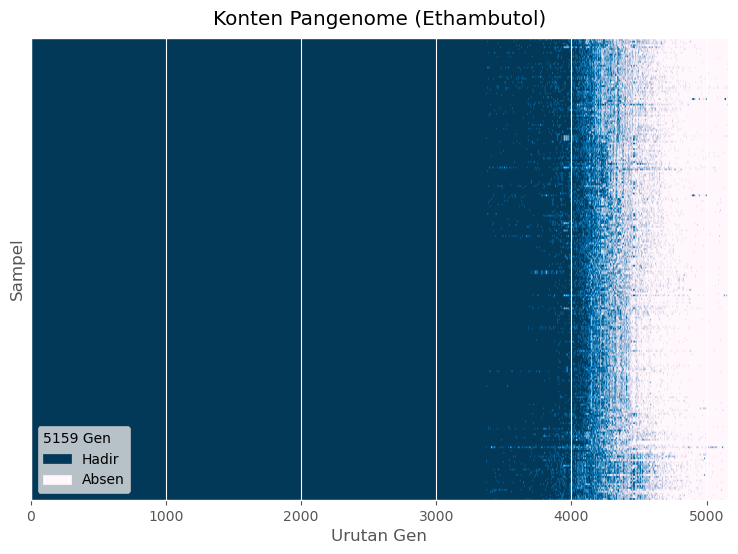

In [11]:
run_pangenome_content_plot('ethambutol')
plt.show()

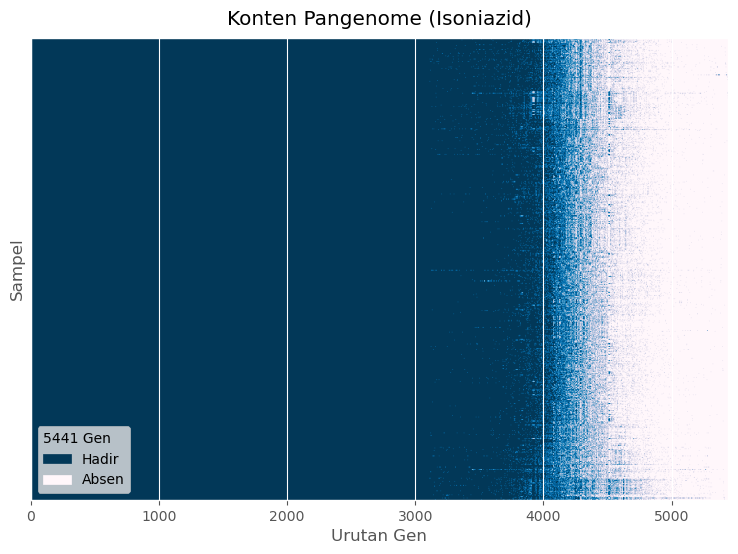

In [12]:
run_pangenome_content_plot('isoniazid')
plt.show()

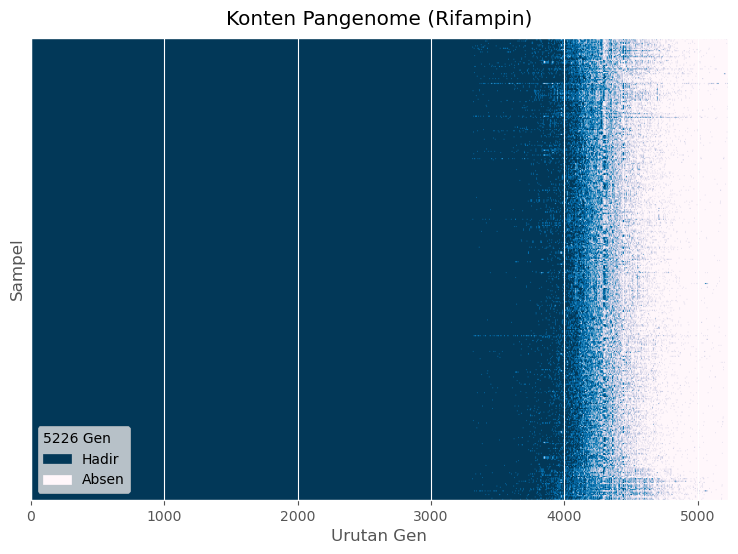

In [13]:
run_pangenome_content_plot('rifampin')
plt.show()